In [1007]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from math import ceil
from datetime import datetime, timedelta

In [1008]:
df = pd.read_csv('dataset_mood_smartphone.csv')

In [1009]:
"""
Check stats on NaN values and Remove NaN values
"""
# df with NaN values
df_na = df[pd.isna(df['value'])]

# Counts NaN values for each variable
df_na_variables = df_na['variable'].value_counts()
df = df.dropna()

In [1010]:
"""
Cut out measurements until continuous measurements of mood for 
"""

'\nCut out measurements until continuous measurements of mood for \n'

In [1011]:
df['time'] = pd.to_datetime(df['time'])
# df['date'] = df['time'].dt.date

df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.floor('D')  # This normalizes the time part to 00:00, keeping it as Timestamp

df['hour'] = df['time'].dt.hour
df['time_of_day'] = df['time'].dt.time
unique_variables = df['variable'].unique()
participants = df['id'].unique()
days = df['date'].unique()

In [1012]:
"""
Delete time gabs in mood AS14.01, AS14.12, AS14,17
"""

# AS14.01
# Ensure 'date' is in datetime format for easy comparison
# df['date'] = pd.to_datetime(df['date'])

# Define the start and end of the date range to exclude
start_date = pd.to_datetime('2014-02-26')
end_date = pd.to_datetime('2014-03-20')

# Exclude data points for 'id' = 'AS14.01' within the specified date range
df = df[~((df['id'] == 'AS14.01') & (df['date'] >= start_date) & (df['date'] <= end_date))]

# Now filtered_df contains the data excluding the specified date range for 'id' = 'AS14.01'

# AS14.12
# 2014-03-15 - 2014, 3, 26
# Ensure 'date' is in datetime format for easy comparison
df['date'] = pd.to_datetime(df['date'])

# Define the start and end of the date range to exclude
start_date = pd.to_datetime('2014-03-15')
end_date = pd.to_datetime('2014-03-26')

# Exclude data points for 'id' = 'AS14.01' within the specified date range
df = df[~((df['id'] == 'AS14.12') & (df['date'] >= start_date) & (df['date'] <= end_date))]

# AS14.17
# 2014, 3, 20

# Ensure 'date' is in datetime format for easy comparison
df['date'] = pd.to_datetime(df['date'])

# Define the start and end of the date range to exclude
start_date = pd.to_datetime('2014-03-04')
end_date = pd.to_datetime('2014-03-20')

# Exclude data points for 'id' = 'AS14.01' within the specified date range
df = df[~((df['id'] == 'AS14.17') & (df['date'] >= start_date) & (df['date'] <= end_date))]

print(df)

        Unnamed: 0       id                    time        variable   value  \
7                8  AS14.01 2014-03-21 09:00:00.000            mood   6.000   
8                9  AS14.01 2014-03-21 11:00:00.000            mood   6.000   
9               10  AS14.01 2014-03-21 15:00:00.000            mood   7.000   
10              11  AS14.01 2014-03-21 19:00:00.000            mood   6.000   
11              12  AS14.01 2014-03-21 21:00:00.000            mood   6.000   
...            ...      ...                     ...             ...     ...   
376907     2770399  AS14.30 2014-04-11 07:51:16.948  appCat.weather   8.032   
376908     2772465  AS14.30 2014-04-19 11:00:32.747  appCat.weather   3.008   
376909     2774026  AS14.30 2014-04-26 10:19:07.434  appCat.weather   7.026   
376910     2774133  AS14.30 2014-04-27 00:44:48.450  appCat.weather  23.033   
376911     2784435  AS14.32 2014-04-07 18:25:14.036  appCat.weather  22.431   

             date  hour      time_of_day  
7      2

In [1013]:
# """
# Distribution of mood over the day
# """
# 
# # Assuming df is your DataFrame and it contains a 'time' column in datetime format
# # Extract just the time component and normalize to a single day
# df['normalized_time'] = pd.to_datetime(df['time'].dt.strftime('2000-01-01 %H:%M:%S')) 
# 
# # Assuming 'variable' column exists and indicates the type of measurement
# mood_measurements = df[df['variable'] == 'mood']
# 
# # Group by the normalized time
# time_counts = mood_measurements.groupby('normalized_time').size().reset_index(name='counts')
# 
# # Plotting
# plt.figure(figsize=(12, 6))
# plt.scatter(time_counts['normalized_time'], time_counts['counts'], marker='o')
# 
# # Format the x-axis to show time of day
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
# 
# plt.xticks(rotation=45)
# plt.xlabel('Time of Day')
# plt.ylabel('Mood Measurement Counts')
# plt.title('Distribution of Mood Measurements Over a Single Day')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [1014]:
"""
Cut out all mood measurements outside the time frame 
08:00 - 22:00
"""


# Filter out mood data outside the 08:00 to 22:00 range
# This is done by first selecting rows that are not 'mood' variables,
# or rows that are 'mood' variables but within the desired time range
df= df[
    (df['variable'] != 'mood') | 
    ((df['time'].dt.hour >= 8) & (df['time'].dt.hour < 22))
]
print(df)

        Unnamed: 0       id                    time        variable   value  \
7                8  AS14.01 2014-03-21 09:00:00.000            mood   6.000   
8                9  AS14.01 2014-03-21 11:00:00.000            mood   6.000   
9               10  AS14.01 2014-03-21 15:00:00.000            mood   7.000   
10              11  AS14.01 2014-03-21 19:00:00.000            mood   6.000   
11              12  AS14.01 2014-03-21 21:00:00.000            mood   6.000   
...            ...      ...                     ...             ...     ...   
376907     2770399  AS14.30 2014-04-11 07:51:16.948  appCat.weather   8.032   
376908     2772465  AS14.30 2014-04-19 11:00:32.747  appCat.weather   3.008   
376909     2774026  AS14.30 2014-04-26 10:19:07.434  appCat.weather   7.026   
376910     2774133  AS14.30 2014-04-27 00:44:48.450  appCat.weather  23.033   
376911     2784435  AS14.32 2014-04-07 18:25:14.036  appCat.weather  22.431   

             date  hour      time_of_day  
7      2

In [1015]:
"""
Cut out all measurements on all variables for each participant outside the timeframe in which mood was measured
"""
# Initialize an empty DataFrame to hold the filtered data
filtered_df = pd.DataFrame()

for participant in participants:
    # Get the mood data for the current participant
    id_df = df[(df['variable'] == 'mood') & (df['id'] == participant)]
    
    # Calculate start and end dates for mood measurements
    start_date = id_df['date'].min()
    end_date = id_df['date'].max()
    
    # Filter the original df to keep rows within the date range for this participant
    participant_data = df[df['id'] == participant]
    participant_filtered = participant_data[(participant_data['date'] >= start_date) & (participant_data['date'] <= end_date)]
    
    # Append the filtered data to the cumulative DataFrame
    filtered_df = pd.concat([filtered_df, participant_filtered], ignore_index=True)
    
# print(filtered_df)
df = filtered_df
print(df)
# Now, filtered_df contains only the data for each participant within the date ranges of their mood measurements.

# Print df to check results
print(df[(df['variable'] == 'mood')])

        Unnamed: 0       id                    time          variable   value  \
0                8  AS14.01 2014-03-21 09:00:00.000              mood   6.000   
1                9  AS14.01 2014-03-21 11:00:00.000              mood   6.000   
2               10  AS14.01 2014-03-21 15:00:00.000              mood   7.000   
3               11  AS14.01 2014-03-21 19:00:00.000              mood   6.000   
4               12  AS14.01 2014-03-21 21:00:00.000              mood   6.000   
...            ...      ...                     ...               ...     ...   
370508     2567224  AS14.33 2014-05-30 10:53:14.276  appCat.utilities  76.903   
370509     2567225  AS14.33 2014-05-30 11:42:41.286  appCat.utilities   4.051   
370510     2567315  AS14.33 2014-05-30 15:05:58.599  appCat.utilities   4.306   
370511     2567367  AS14.33 2014-05-30 20:06:23.109  appCat.utilities   2.006   
370512     2567452  AS14.33 2014-05-30 22:32:05.016  appCat.utilities   6.019   

             date  hour    

In [1016]:
"""
Detecting outliers with IQR
"""
def get_outlier_indices(group, threshold=6.0):
    Q1 = group['value'].quantile(0.25)
    Q3 = group['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    # Find outliers and return their indices
    outlier_mask = (group['value'] < lower_bound) | (group['value'] > upper_bound)
    if outlier_mask.any():
        return group[outlier_mask].index.tolist()
    else:
        return []

# Exclude 'mood' data before applying outlier detection
df_filtered = df[df['variable'] != 'mood']

# Get indices of outliers in each group
outlier_indices = df_filtered.groupby('variable').apply(get_outlier_indices).explode()

# Convert Series to list, filtering out NaN values if any (resulting from empty lists)
outlier_indices = [idx for idx in outlier_indices if pd.notna(idx)]

# Drop the outliers by index to create a new DataFrame without outliers
df_without_outliers = df.drop(outlier_indices)

# Print the original and new DataFrame sizes to see the effect
print(f"Original DataFrame size: {len(df)}")
print(f"DataFrame size without outliers: {len(df_without_outliers)}")

df = df_without_outliers

Original DataFrame size: 370513
DataFrame size without outliers: 359655


In [1017]:
# # import pandas as pd
# 
# # Assuming df is your DataFrame and it contains 'id', 'date', 'variable', and 'value'
# # Ensure 'date' is in datetime format
# df['date'] = pd.to_datetime(df['date']).dt.date  # just use date part
# 
# # Specify variables of interest
# variables_of_interest = ['mood', 'circumplex.arousal', 'circumplex.valence']
# 
# # Initialize an empty DataFrame to hold all new entries
# new_entries_df = pd.DataFrame()
# 
# # Get date ranges for mood data per participant
# mood_data = df[df['variable'] == 'mood']
# date_ranges = mood_data.groupby('id')['date'].agg(start_date='min', end_date='max')
# 
# # Loop through each participant
# for participant_id, row in date_ranges.iterrows():
#     start_date = row['start_date']
#     end_date = row['end_date']
#     all_dates = pd.date_range(start_date, end_date, freq='D')
# 
#     # Check existing dates for the participant in the variables of interest
#     participant_data = df[(df['id'] == participant_id) & (df['variable'].isin(variables_of_interest))]
#     existing_dates = participant_data['date'].unique()
# 
#     # Determine missing dates
#     missing_dates = set(all_dates.date) - set(existing_dates)
# 
#     # Handle missing dates by interpolating
#     for missing_date in missing_dates:
#         for variable in variables_of_interest:
#             # Create a mask for two days around the missing date
#             mask_dates = pd.date_range(missing_date - pd.Timedelta(days=1), missing_date + pd.Timedelta(days=1), freq='D').date
#             mask = (df['id'] == participant_id) & (df['variable'] == variable) & (df['date'].isin(mask_dates))
#             relevant_data = df.loc[mask, 'value']
# 
#             if not relevant_data.empty:
#                 # Compute the mean value
#                 mean_value = relevant_data.mean()
# 
#                 # Prepare a new entry
#                 new_entry = {
#                     'id': participant_id,
#                     'date': pd.Timestamp(missing_date),
#                     'variable': variable,
#                     'value': mean_value,
#                     'time': pd.Timestamp(missing_date).replace(hour=12)  # setting time as noon
#                 }
#                 new_entries_df = new_entries_df.append(new_entry, ignore_index=True)
# 
# # Combine new entries with the original dataframe
# df = pd.concat([df, new_entries_df], ignore_index=True)
# 
# 
# # Print df to check results
# print(df[(df['variable'] == 'mood')])
# # print(df.loc(df['variable'] == 'mood'))
# 
# # Assuming df is your DataFrame
# df.fillna(0, inplace=True)
# 
# # Print df to check that all NaN values have been replaced by zeros
# print(df)


In [1018]:
"""
Detecting outliers with IQR
"""

# Function to detect outliers within a group
def detect_outliers(group):
    Q1 = group['value'].quantile(0.25)
    Q3 = group['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Return only outliers within the group
    return group[(group['value'] < lower_bound) | (group['value'] > upper_bound)]

# Group by participant and apply the outlier detection
outliers_by_variable_df = df.groupby('variable').apply(detect_outliers).reset_index(drop=True)

# print("Outliers detected within each variable:")
# print(outliers_by_variable_df)

outliers_count_per_variable = outliers_by_variable_df.groupby('variable')['value'].count().reset_index(name='count')
print(outliers_count_per_variable)


                variable  count
0               activity   2203
1         appCat.builtin   7993
2   appCat.communication   5635
3   appCat.entertainment   3440
4         appCat.finance    103
5            appCat.game     86
6          appCat.office    709
7           appCat.other    780
8          appCat.social   1622
9          appCat.travel    159
10        appCat.unknown     64
11      appCat.utilities    151
12        appCat.weather      9
13    circumplex.valence     31
14                  mood    385
15                screen   8201


In [1019]:
active_subjects_hour = df.groupby(['hour'])['id'].unique().reset_index()
active_subjects_day = df.groupby(['date'])['id'].unique().reset_index()

In [1020]:
"""
Average data for each day:
"""
# non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence']
df_time = df[~df['variable'].isin(non_time_variables)]

# For time variables, we take the mean of each day averaged over the active participants of the corresponding day
daily_avg_df_time = df_time.groupby(['date', 'variable'])['value'].sum().reset_index()
daily_avg_df_time['value'] = daily_avg_df_time['value'] / len(active_subjects_day['date'])

# For non-time variables, we take the mean of all the inputs for each hour
df_non_time = df[df['variable'].isin(non_time_variables)]
daily_avg_df_non_time = df_non_time.groupby(['date', 'variable'])['value'].mean().reset_index()

# Merges the two dataframes
daily_avg_df = pd.concat([daily_avg_df_non_time, daily_avg_df_time], ignore_index=True)

In [1021]:
"""
Stats on data
"""
print(f'Amount of measured variables: {len(unique_variables)}')
print(f'Amount of participants: {len(participants)}')
print(f'Experiment took place over {len(days)} days')
for variable in unique_variables:
    print(len(daily_avg_df['variable'] == variable))
print(daily_avg_df[daily_avg_df['variable'] == 'mood'])

##

Amount of measured variables: 19
Amount of participants: 27
Experiment took place over 113 days
1480
1480
1480
1480
1480
1480
1480
1480
1480
1480
1480
1480
1480
1480
1480
1480
1480
1480
1480
          date variable     value
2   2014-03-05     mood  6.333333
5   2014-03-06     mood  7.200000
8   2014-03-07     mood  7.400000
11  2014-03-08     mood  7.000000
14  2014-03-09     mood  7.200000
..         ...      ...       ...
272 2014-06-04     mood  7.000000
275 2014-06-05     mood  7.000000
278 2014-06-06     mood  7.500000
280 2014-06-07     mood  8.000000
283 2014-06-08     mood  7.000000

[95 rows x 3 columns]


Text(0.5, 1.0, 'Correlation Heatmap of Variables')

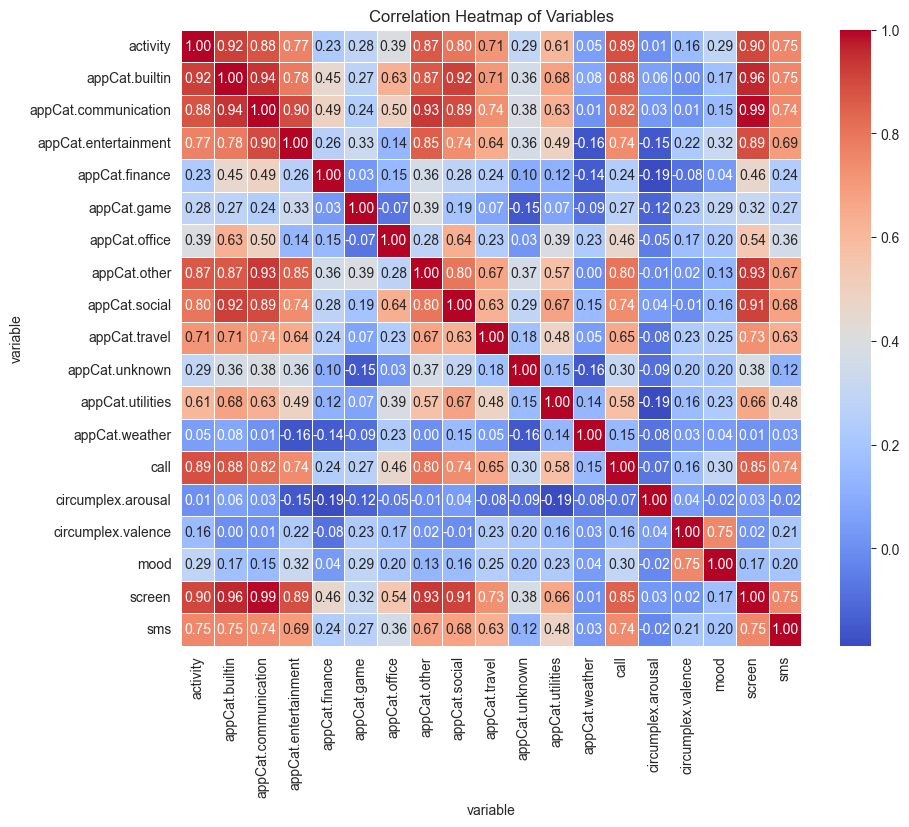

In [1022]:
"""
Corr. heatmap, index on date
"""
df_pivoted = daily_avg_df.pivot_table(index='date', columns='variable', values='value')
corr_matrix = df_pivoted.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Variables')

In [1023]:
"""
Average data for each hour
"""
non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
df_time = df[~df['variable'].isin(non_time_variables)]

# For time variables, we take the mean of each hour averaged over the active participants of the corresponding hour
hourly_avg_df_time = df_time.groupby(['hour', 'variable'])['value'].sum().reset_index()
hourly_avg_df_time['value'] = hourly_avg_df_time['value'] / len(active_subjects_hour['hour'])

# For non-time variables, we take the mean of all the inputs of each day
df_non_time = df[df['variable'].isin(non_time_variables)]
hourly_avg_df_non_time = df_non_time.groupby(['hour', 'variable'])['value'].mean().reset_index()

# Merges the two dataframes
hourly_avg_df = pd.concat([hourly_avg_df_non_time, hourly_avg_df_time], ignore_index=True)

Text(0.5, 1.0, 'Correlation Heatmap of Variables')

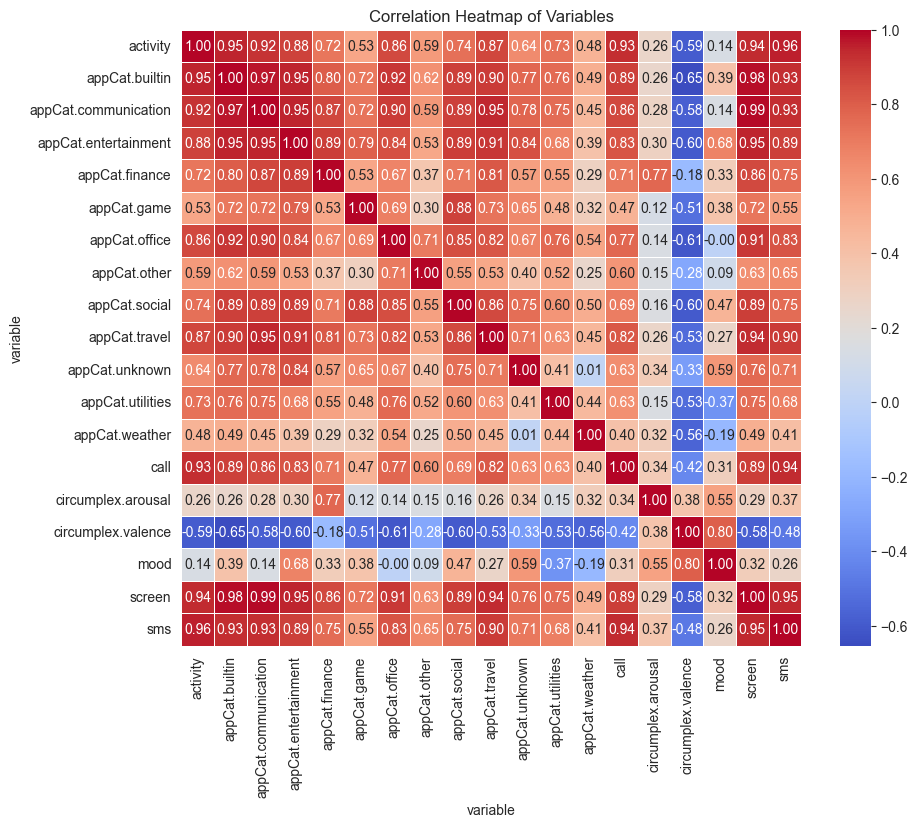

In [1024]:
"""
Corr. heatmap, index on hour
"""
df_pivoted = hourly_avg_df.pivot_table(index='hour', columns='variable', values='value')
corr_matrix = df_pivoted.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Variables')

In [1025]:
# """
# Calculate end and start date of data collection on each variable
# Conclusion: There are only 49 days of which between the latest starting date and the earliest stop date of measuring the predictors.
# """
# start_dates = []
# end_dates = []
# 
# for variable in unique_variables:
#     var_df = df.loc[df['variable'] == variable]
#     start_date = var_df['date'].min()
#     start_dates.append(start_date)
#     end_date = var_df['date'].max()
#     end_dates.append(end_date)
#     print(f'var: {variable}, start: {start_date}, end: {end_date}')
# 
# max_start_date = max(start_dates)
# min_end_date = min(end_dates)
# 
# print('')
# print(f'Latest start date: {max_start_date}, earliest end date: {min_end_date}')

In [1026]:
# for variable in unique_variables:
#     print(len(hourly_avg_df['variable'] == variable))
# print(daily_avg_df[hourly_avg_df['variable'] == 'mood'])

ID: AS14.01, Start: 2014-03-21 00:00:00, End: 2014-05-04 00:00:00, Timeframe: 44 days 00:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.01.


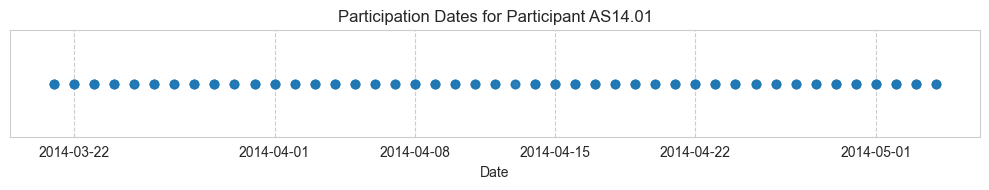

ID: AS14.02, Start: 2014-03-16 00:00:00, End: 2014-04-25 00:00:00, Timeframe: 40 days 00:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.02.


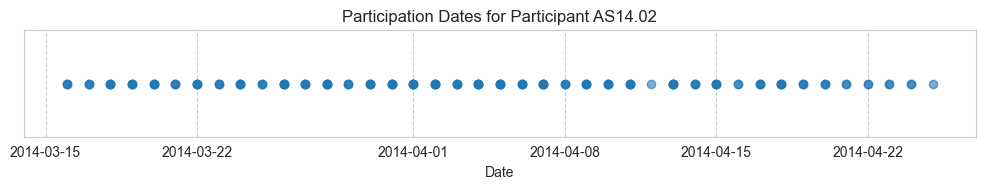

ID: AS14.03, Start: 2014-03-21 00:00:00, End: 2014-05-07 00:00:00, Timeframe: 47 days 00:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.03: [datetime.date(2014, 5, 6)]


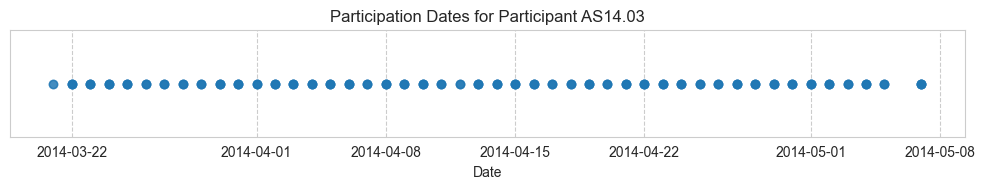

ID: AS14.05, Start: 2014-03-14 00:00:00, End: 2014-05-05 00:00:00, Timeframe: 52 days 00:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.05.


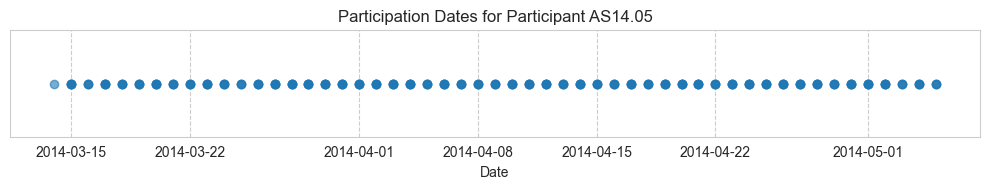

ID: AS14.06, Start: 2014-03-24 00:00:00, End: 2014-05-08 00:00:00, Timeframe: 45 days 00:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.06: [datetime.date(2014, 5, 6)]


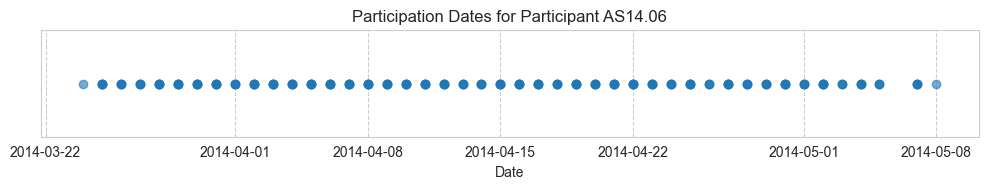

ID: AS14.07, Start: 2014-03-19 00:00:00, End: 2014-05-05 00:00:00, Timeframe: 47 days 00:00:00 
 Missing Dates: 3
Missing mood measurement dates for participant AS14.07: [datetime.date(2014, 4, 20), datetime.date(2014, 4, 29), datetime.date(2014, 5, 4)]


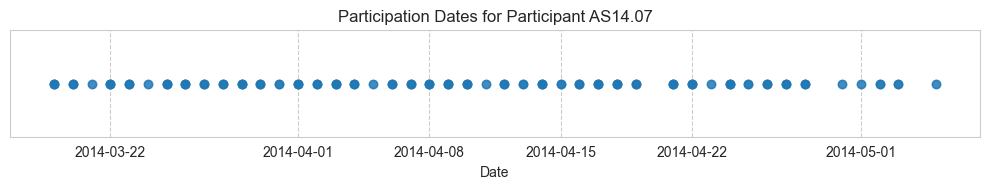

ID: AS14.08, Start: 2014-03-05 00:00:00, End: 2014-05-05 00:00:00, Timeframe: 61 days 00:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.08.


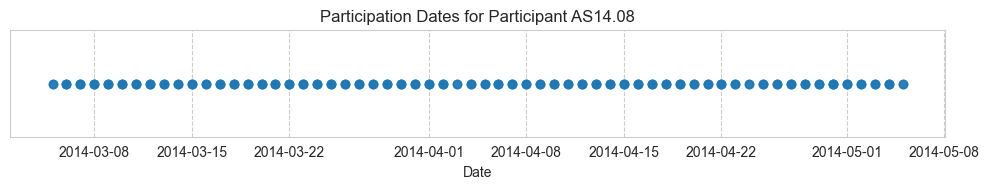

ID: AS14.09, Start: 2014-03-21 00:00:00, End: 2014-05-05 00:00:00, Timeframe: 45 days 00:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.09.


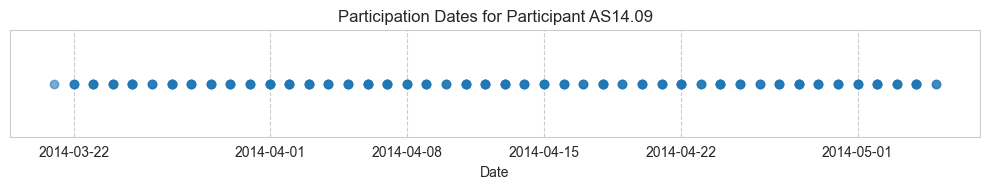

ID: AS14.12, Start: 2014-03-27 00:00:00, End: 2014-05-05 00:00:00, Timeframe: 39 days 00:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.12.


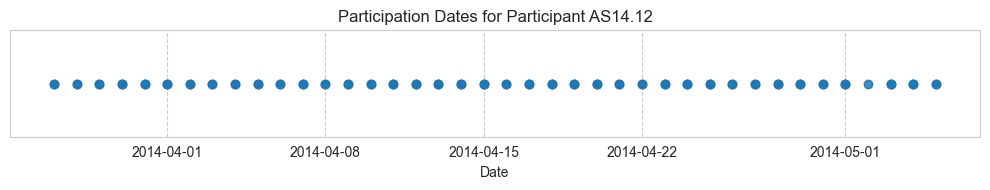

ID: AS14.13, Start: 2014-03-13 00:00:00, End: 2014-05-03 00:00:00, Timeframe: 51 days 00:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.13.


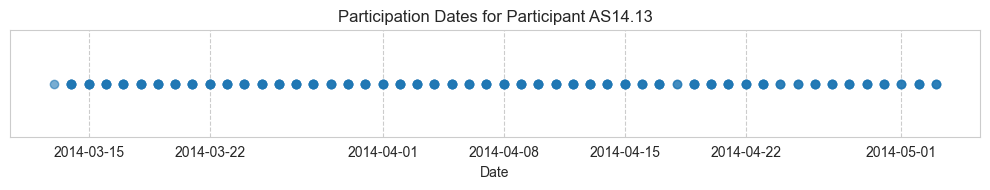

ID: AS14.14, Start: 2014-03-20 00:00:00, End: 2014-05-05 00:00:00, Timeframe: 46 days 00:00:00 
 Missing Dates: 3
Missing mood measurement dates for participant AS14.14: [datetime.date(2014, 4, 13), datetime.date(2014, 4, 28), datetime.date(2014, 4, 29)]


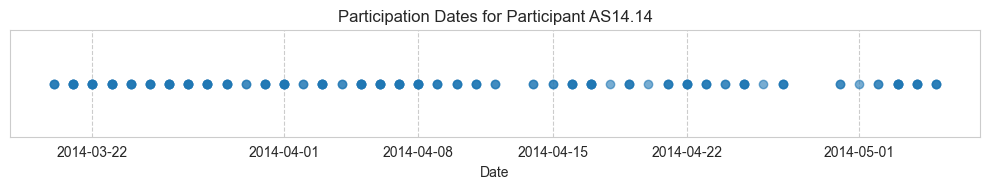

ID: AS14.15, Start: 2014-03-14 00:00:00, End: 2014-05-08 00:00:00, Timeframe: 55 days 00:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.15: [datetime.date(2014, 5, 6)]


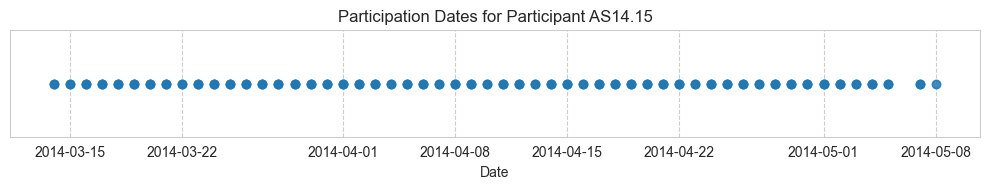

ID: AS14.16, Start: 2014-03-13 00:00:00, End: 2014-05-05 00:00:00, Timeframe: 53 days 00:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.16: [datetime.date(2014, 5, 3)]


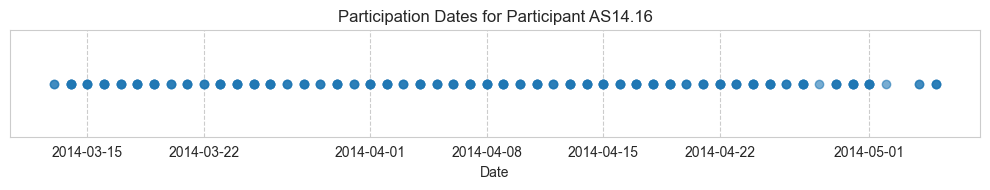

ID: AS14.17, Start: 2014-03-21 00:00:00, End: 2014-05-05 00:00:00, Timeframe: 45 days 00:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.17: [datetime.date(2014, 5, 4)]


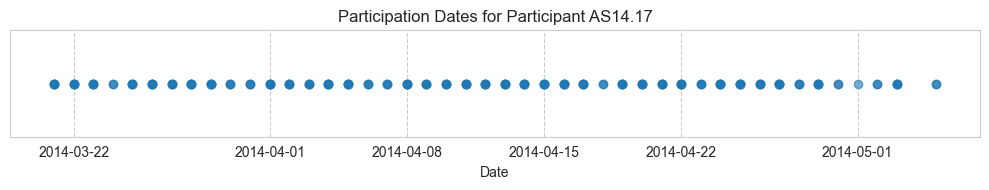

ID: AS14.19, Start: 2014-03-21 00:00:00, End: 2014-05-05 00:00:00, Timeframe: 45 days 00:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.19.


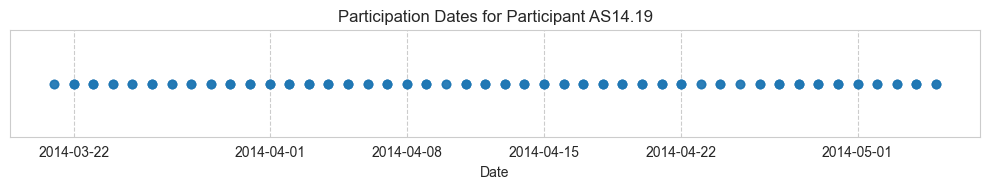

ID: AS14.20, Start: 2014-03-20 00:00:00, End: 2014-05-05 00:00:00, Timeframe: 46 days 00:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.20.


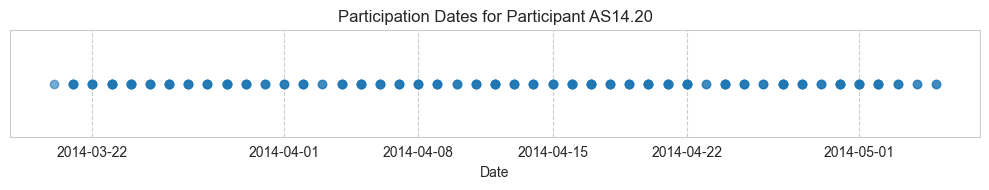

ID: AS14.23, Start: 2014-03-22 00:00:00, End: 2014-04-30 00:00:00, Timeframe: 39 days 00:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.23: [datetime.date(2014, 4, 14)]


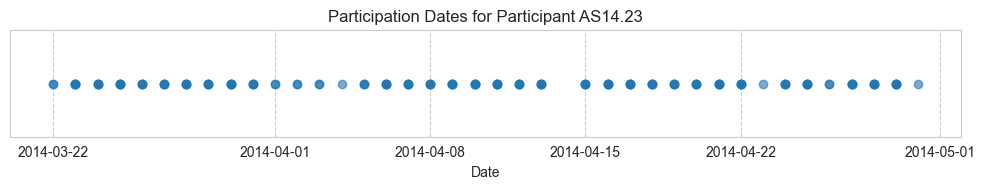

ID: AS14.24, Start: 2014-04-14 00:00:00, End: 2014-06-08 00:00:00, Timeframe: 55 days 00:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.24: [datetime.date(2014, 5, 6)]


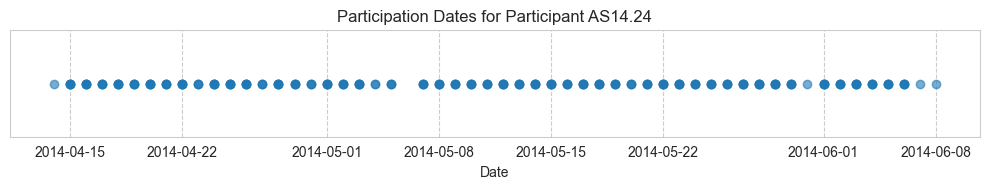

ID: AS14.25, Start: 2014-04-08 00:00:00, End: 2014-05-08 00:00:00, Timeframe: 30 days 00:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.25: [datetime.date(2014, 5, 6)]


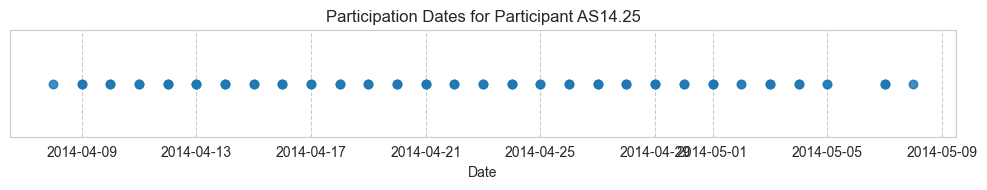

ID: AS14.26, Start: 2014-03-23 00:00:00, End: 2014-05-30 00:00:00, Timeframe: 68 days 00:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.26: [datetime.date(2014, 5, 6)]


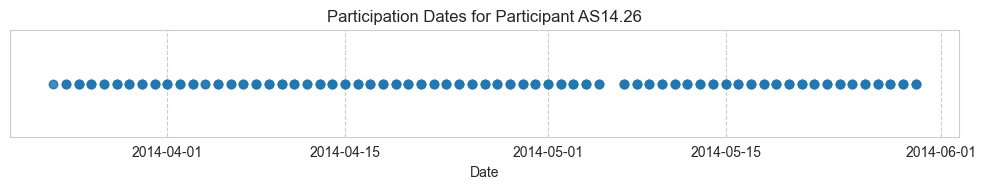

ID: AS14.27, Start: 2014-04-03 00:00:00, End: 2014-05-15 00:00:00, Timeframe: 42 days 00:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.27: [datetime.date(2014, 5, 6)]


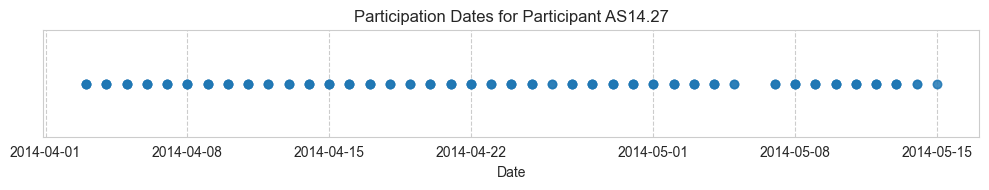

ID: AS14.28, Start: 2014-03-31 00:00:00, End: 2014-05-08 00:00:00, Timeframe: 38 days 00:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.28: [datetime.date(2014, 5, 6)]


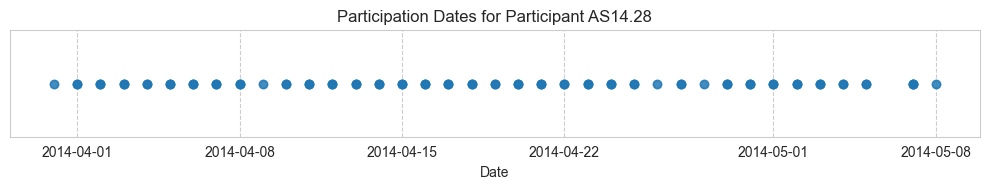

ID: AS14.29, Start: 2014-04-02 00:00:00, End: 2014-05-15 00:00:00, Timeframe: 43 days 00:00:00 
 Missing Dates: 2
Missing mood measurement dates for participant AS14.29: [datetime.date(2014, 5, 2), datetime.date(2014, 5, 6)]


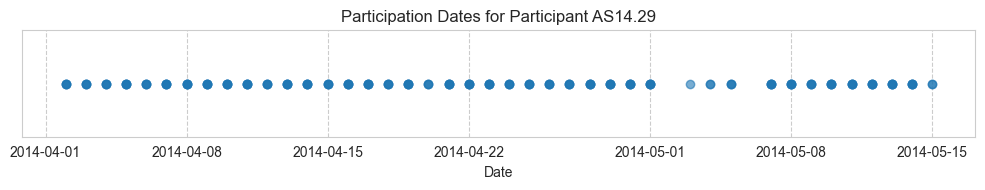

ID: AS14.30, Start: 2014-03-20 00:00:00, End: 2014-05-05 00:00:00, Timeframe: 46 days 00:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.30.


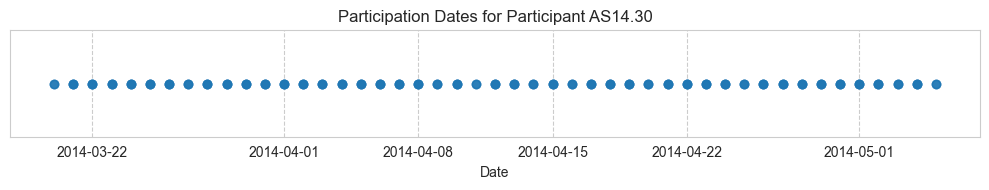

ID: AS14.31, Start: 2014-04-02 00:00:00, End: 2014-05-15 00:00:00, Timeframe: 43 days 00:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.31: [datetime.date(2014, 5, 6)]


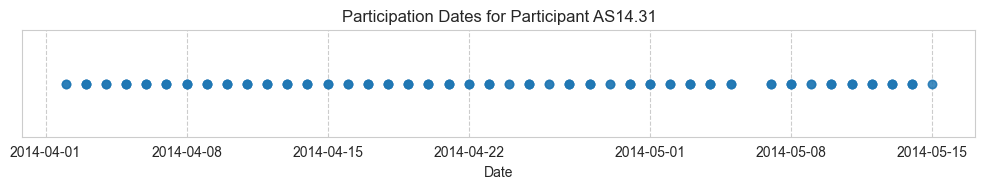

ID: AS14.32, Start: 2014-04-01 00:00:00, End: 2014-05-12 00:00:00, Timeframe: 41 days 00:00:00 
 Missing Dates: 5
Missing mood measurement dates for participant AS14.32: [datetime.date(2014, 4, 19), datetime.date(2014, 4, 20), datetime.date(2014, 4, 22), datetime.date(2014, 4, 26), datetime.date(2014, 5, 6)]


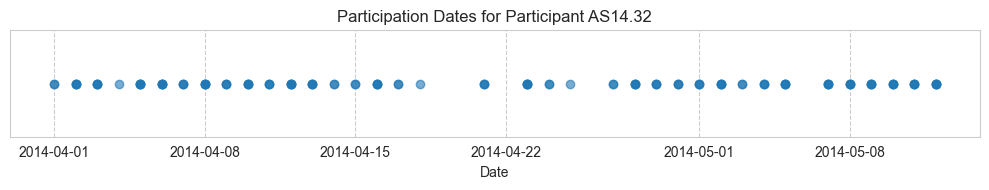

ID: AS14.33, Start: 2014-04-16 00:00:00, End: 2014-05-31 00:00:00, Timeframe: 45 days 00:00:00 
 Missing Dates: 3
Missing mood measurement dates for participant AS14.33: [datetime.date(2014, 5, 2), datetime.date(2014, 5, 3), datetime.date(2014, 5, 6)]


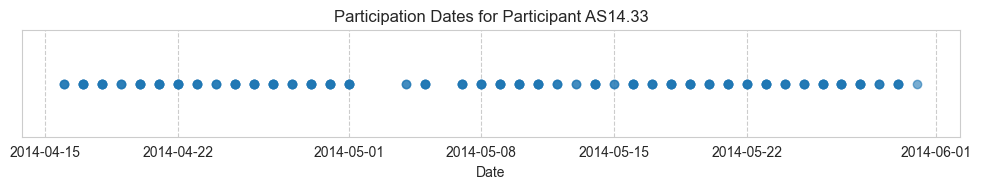

In [1027]:
"""
Calculate end and start date of data collection for each participant. Missing mood dates are printed for each participant.
Conclusion: The amount of times in which mood is measured for the participants varies between 128 and 299 days. The timeframe in days in which mood was measured for each participant varies between 30 days and 67 days. 
"""
start_dates = []
end_dates = []

mood_measurements = df[df['variable'] == 'mood']

for participant in participants:
    id_df = mood_measurements.loc[(mood_measurements['id'] == participant)]

    start_date = id_df['date'].min()
    start_dates.append(start_date)
    end_date = id_df['date'].max()
    end_dates.append(end_date)

    # Convert mood measurement dates to datetime and get unique values
    mood_dates = pd.to_datetime(id_df['date']).dt.date.unique()
    
    # print(f'id: {participant}, start: {start_date}, end: {end_date}, days: {end_date - start_date}, mood count = {len(id_df)}')
    # 
       # Generate a Series of all dates between start and end
    all_dates = pd.date_range(start=start_date, end=end_date).date

 # Check for missing dates by comparing sets
    missing_dates = set(all_dates) - set(mood_dates)
    
    print(f'ID: {participant}, Start: {start_date}, End: {end_date}, Timeframe: {end_date - start_date} \n Missing Dates: {len(missing_dates)}')
    if len(missing_dates) > 0:
        print(f"Missing mood measurement dates for participant {participant}: {sorted(missing_dates)}")
    else:
        print(f"All dates between start and end have at least one mood measurement for participant {participant}.")
    print('')

# Plotting
    plt.figure(figsize=(10, 2))  # Adjust size as needed
    plt.scatter(id_df['date'], [1]*len(id_df), alpha=0.6)  # Plot a dot at y=1 for each date
    
    # Formatting the plot
    plt.title(f'Participation Dates for Participant {participant}')
    plt.yticks([])  # Hide y-axis ticks as they don't convey meaningful information in this case
    plt.xlabel('Date')
    
    # Option to set x-axis limits to cover the entire period of study if desired
    # plt.xlim(pd.to_datetime('start_date'), pd.to_datetime('end_date'))
    
    plt.grid(True, which='major', linestyle='--', axis='x')
    plt.tight_layout()  # Adjust layout to make room for the plot elements
    
    plt.show()

'\nHere I want to give each first day \n'

           date              variable     value
0    2014-03-05    circumplex.arousal  0.000000
1    2014-03-05    circumplex.valence  0.333333
2    2014-03-05                  mood  6.333333
3    2014-03-06    circumplex.arousal -0.600000
4    2014-03-06    circumplex.valence  0.600000
...         ...                   ...       ...
1475 2014-06-08        appCat.builtin  2.800042
1476 2014-06-08  appCat.communication  0.031688
1477 2014-06-08          appCat.other  0.188219
1478 2014-06-08         appCat.social  1.987083
1479 2014-06-08                screen  1.161031

[1480 rows x 3 columns]
